In [1]:
import numpy as np 
# import pandas as pd 
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from glob import glob
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
# plt.rcParams['figure.figsize'] = (20,20)

from tensorflow.keras import Model

from PIL import Image

2024-05-20 13:07:50.520669: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-20 13:07:51.294410: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Data Preparation

In [2]:
#directory
train_dir = 'BinaryPneumoniaBroncho/Train'
val_dir = 'BinaryPneumoniaBroncho/Test'

In [3]:
#visualize Image before Augmentation
train_pneumonia_img = glob(train_dir + '/Pneumonia/*.PNG') + glob(train_dir + '/Pneumonia/*.png') + glob(train_dir + '/Pneumonia/*.jpg') + glob(train_dir + '/Pneumonia/*.jpeg')
train_bronchopneumonia_img = glob(train_dir + '/Bronchopneumonia/*.PNG') + glob(train_dir + '/Bronchopneumonia/*.png') + glob(train_dir + '/Bronchopneumonia/*.jpg') + glob(train_dir + '/Bronchopneumonia/*.jpeg')

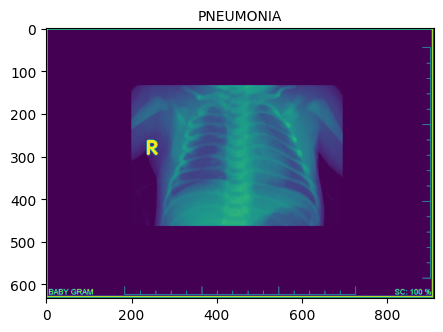

(633, 909)


In [4]:
pneumonia_img = Image.open(train_pneumonia_img[0])

#convert RGBA to RGB
# pneumonia_rgb = pneumonia_img.convert('RGB')

#convert to grayscale
pneumonia_gray = pneumonia_img.convert('L')

pneumonia = np.asarray(pneumonia_gray)

plt.figure(figsize=(5, 5))
plt.title('PNEUMONIA', fontsize=10, color='black')
plt.imshow(pneumonia)
plt.show()

print(pneumonia.shape)

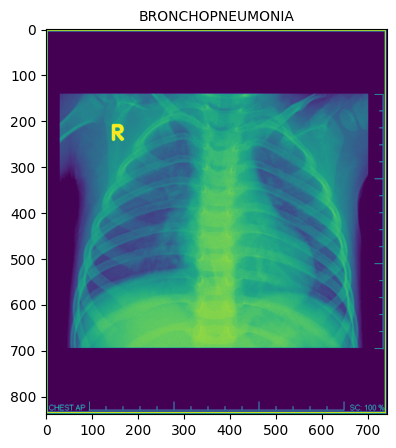

(839, 742)


In [5]:
bronchopneumonia_img = Image.open(train_bronchopneumonia_img[0])

#convert RGBA to RGB
# pneumonia_rgb = pneumonia_img.convert('RGB')

#convert to grayscale
bronchopneumonia_gray = bronchopneumonia_img.convert('L')

bronchopneumonia = np.asarray(bronchopneumonia_gray)

plt.figure(figsize=(5, 5))
plt.title('BRONCHOPNEUMONIA', fontsize=10, color='black')
plt.imshow(bronchopneumonia)
plt.show()

print(bronchopneumonia.shape)

Data Preprocessing

In [6]:
from skimage import exposure

# Define a custom preprocessing function to adjust brightness and contrast
def adjust_brightness_contrast(image):
    # Adjust brightness and contrast using skimage
    image = exposure.adjust_gamma(image, gamma=1.08)  # Example gamma value, adjust as needed
    return image


In [7]:
#ImageDataGenerator for training and test
datagen = ImageDataGenerator(validation_split = 0.30,
                             rescale = 1./255,
                             preprocessing_function=adjust_brightness_contrast,
                             horizontal_flip = False,
                             vertical_flip = False)
#ImageDataGenerator for val set
val_datagen = ImageDataGenerator(rescale=1./255,
                                preprocessing_function=adjust_brightness_contrast)

In [8]:
IMG_SIZE = (224,224)
train_set = datagen.flow_from_directory(train_dir,
                                        subset = 'training',
                                        classes = ['Pneumonia', 'Bronchopneumonia'],
                                        class_mode = 'binary',
                                        batch_size = 16,
                                        target_size = IMG_SIZE)

Found 76 images belonging to 2 classes.


In [9]:
test_set = datagen.flow_from_directory(train_dir,
                                       subset = 'validation',
                                       classes = ['Pneumonia', 'Bronchopneumonia'],
                                       class_mode = 'binary',
                                       batch_size = 16,
                                       target_size = IMG_SIZE)

Found 31 images belonging to 2 classes.


In [10]:
for batch in train_set:
    X_train, y_train = batch
    break #Exit loop after processing the first batch

for batch in test_set:
    X_test, y_test = batch
    break

In [11]:
print(len(X_train), len(y_train))

16 16


In [12]:
print('Train X=%s Y=%s' %(X_train.shape, y_train.shape))
print('Test X=%s Y=%s' %(X_test.shape, y_test.shape))

Train X=(16, 224, 224, 3) Y=(16,)
Test X=(16, 224, 224, 3) Y=(16,)


<Axes: xlabel='count'>

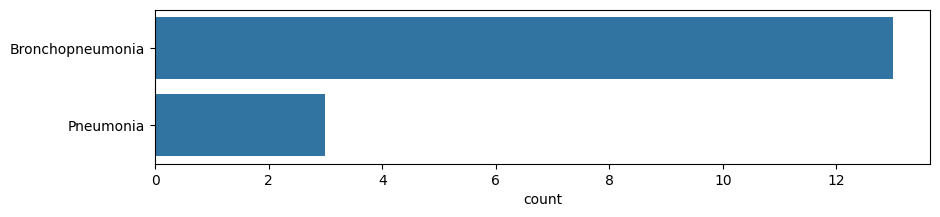

In [13]:
labels = ['Pneumonia' if label == 0 else 'Bronchopneumonia' for label in y_train]
fig = plt.subplots(figsize=(10,2))
sns.countplot(labels)

#check the labels, 0 for what?

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

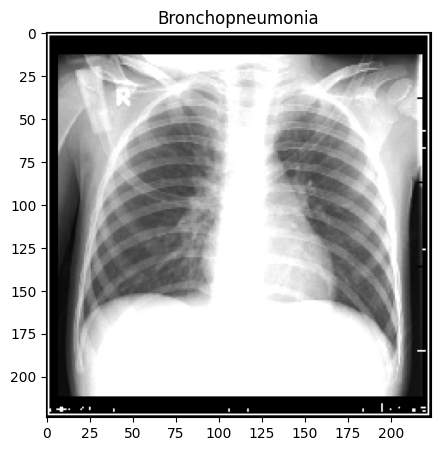

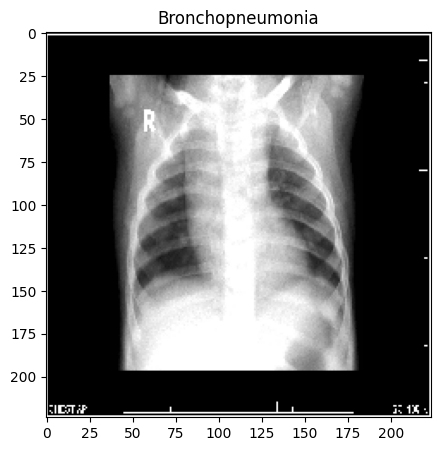

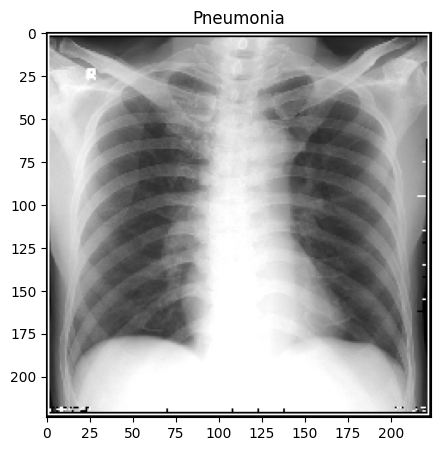

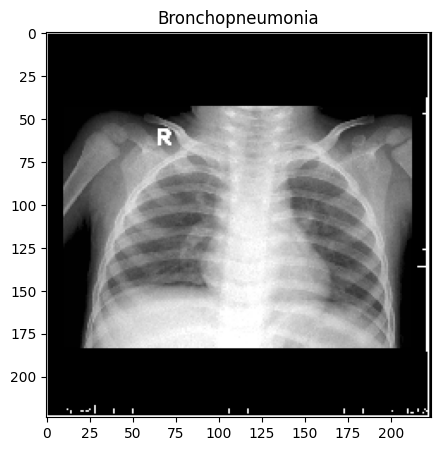

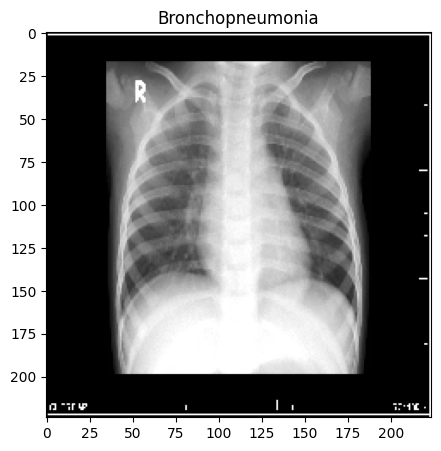

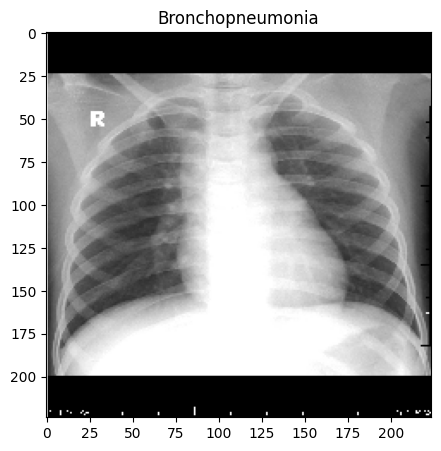

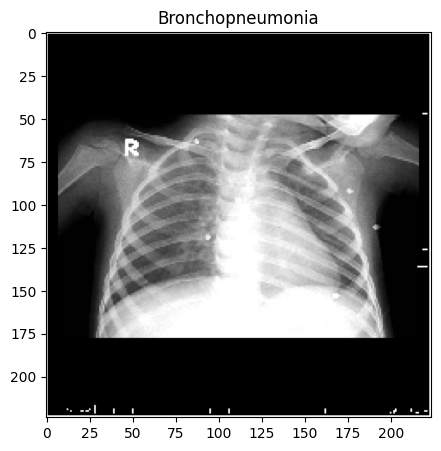

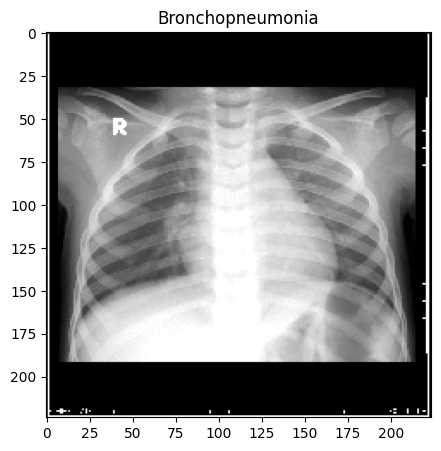

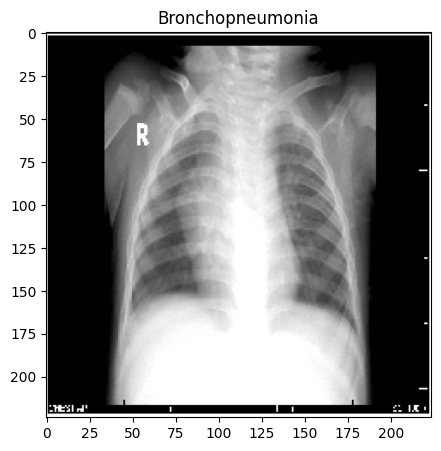

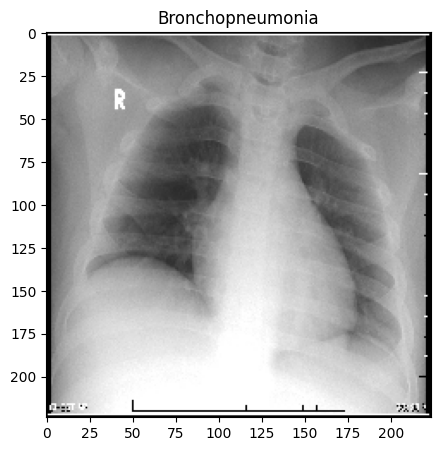

In [14]:
for augdata in range(10):
    plt.figure(figsize=(5,5))
    plt.imshow(X_train[augdata])
    plt.title(labels[augdata])

#why the green background?

In [15]:
X_train[0].shape

(224, 224, 3)

In [16]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('V10_VGG16PneumoniaBroncho.keras')

class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.93 and logs.get('val_accuracy') > 0.93) and (logs.get('loss') <= 0.3 and logs.get('val_loss') <= 0.3):
            if logs.get('accuracy') <= logs.get('val_accuracy'):
                self.model.stop_training = True
            else:
                self.model.stop_training = False

custom_cb = CustomCallback()

In [17]:
VGGModel = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(224,224,3),
    pooling=None,
    classifier_activation='softmax'
)

VGGModel.trainable = False

2024-05-20 13:07:58.005940: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-20 13:07:58.009588: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [18]:
x = tf.keras.layers.Flatten()(VGGModel.output)
x = tf.keras.layers.Dense(2048, activation = 'relu')(x)
# x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(4096, activation = 'relu')(x)
# x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = Model(inputs=VGGModel.input, outputs=outputs)

In [19]:
# x = tf.keras.layers.Flatten()(VGGModel.output)
# x = tf.keras.layers.Dense(2048, activation = 'relu')(x)
# # x = tf.keras.layers.Dropout(0.2)(x)
# x = tf.keras.layers.Dense(4096, activation = 'relu')(x)
# # x = tf.keras.layers.Dropout(0.2)(x)
# outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
# model = Model(inputs=VGGModel.input, outputs=outputs)

In [20]:
# model.summary()

In [21]:
model.compile(loss='binary_crossentropy',
                       optimizer=tf.optimizers.Adam(),
                       metrics=['accuracy'])

In [22]:
hist = model.fit(
    train_set,
    validation_data = test_set,
    epochs = 32,
    callbacks=[checkpoint_cb])

Epoch 1/32


/home/isb/anaconda3/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.5497 - loss: 8.4237 - val_accuracy: 0.5806 - val_loss: 1.7090
Epoch 2/32
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.4864 - loss: 1.2754 - val_accuracy: 0.7419 - val_loss: 0.5741
Epoch 3/32
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.8431 - loss: 0.4785 - val_accuracy: 0.7097 - val_loss: 0.7264
Epoch 4/32
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.8738 - loss: 0.3305 - val_accuracy: 0.6774 - val_loss: 0.7744
Epoch 5/32
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.8345 - loss: 0.3429 - val_accuracy: 0.8065 - val_loss: 0.6667
Epoch 6/32
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9190 - loss: 0.1501 - val_accuracy: 0.7419 - val_loss: 0.6503
Epoch 7/32
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.9529 - loss: 0.1240 - val_accuracy: 0.7742 - val_loss: 0.7188
Epoch 8/32
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.9831 - loss: 0.0506 - val_accuracy: 0.7419 - val_loss: 0.9449
Epoch 9/32
5/5 ━━━━━━━━━━

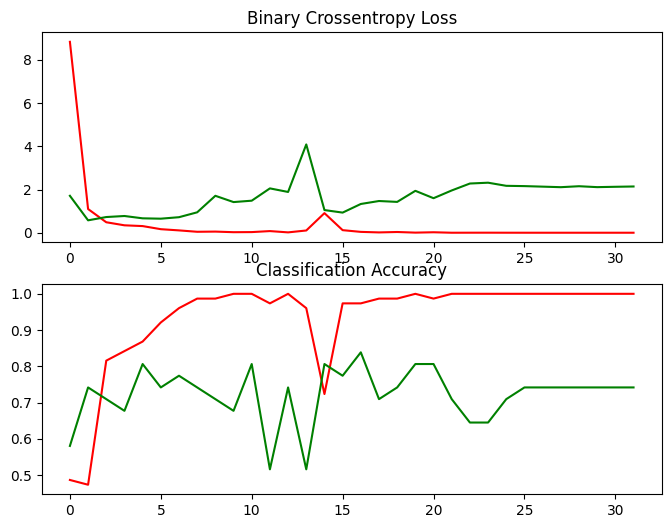

In [23]:
plt.figure(figsize=(8, 6)) 

plt.subplot(211)
plt.title('Binary Crossentropy Loss')
plt.plot(hist.history['loss'], color = 'red', label ='train')
plt.plot(hist.history['val_loss'], color = 'green', label ='val')

plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(hist.history['accuracy'], color = 'red', label ='train')
plt.plot(hist.history['val_accuracy'], color = 'green', label ='test')

plt.show()

Make Predictions

In [24]:
val_datagen = ImageDataGenerator(rescale=1./255)

val_set = val_datagen.flow_from_directory(val_dir,
                                          batch_size = 16,
                                          classes = ['Pneumonia','Bronchopneumonia'],
                                          target_size = IMG_SIZE,
                                          class_mode='binary')
X_val, y_val = next(val_set)

Found 33 images belonging to 2 classes.


In [25]:
print('Loss of the model is - ', model.evaluate(X_val, y_val)[0])
print('Accuracy of the model is - ', model.evaluate(X_val, y_val)[1]*100,'%')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.8125 - loss: 0.4803
Loss of the model is -  0.48028188943862915
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.8125 - loss: 0.4803
Accuracy of the model is -  81.25 %


In [26]:
# Assuming model is your Keras model
predicted_probabilities = model.predict(X_val)
predicted_classes = (predicted_probabilities > 0.5).astype(int)  # Use a threshold of 0.5 for binary classification
predicted_classes = predicted_classes.reshape(1, -1)[0]
predicted_classes

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


array([0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0])

In [27]:
# Assuming model is your Keras model
predicted_probabilities = model.predict(X_test)
predicted_test = (predicted_probabilities > 0.5).astype(int)  # Use a threshold of 0.5 for binary classification
predicted_test = predicted_classes.reshape(1, -1)[0]
predicted_test

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


array([0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0])

In [28]:
print(np.unique(predicted_test))

[0 1]


In [29]:
print(classification_report(y_val, predicted_classes, target_names = ['Pneumonia (Class 0)','Bronchopneumonia (Class 1)']))

                            precision    recall  f1-score   support

       Pneumonia (Class 0)       0.83      0.71      0.77         7
Bronchopneumonia (Class 1)       0.80      0.89      0.84         9

                  accuracy                           0.81        16
                 macro avg       0.82      0.80      0.81        16
              weighted avg       0.81      0.81      0.81        16



In [30]:
print(len(y_test))
print(len(predicted_test))

16
16


In [31]:
print(classification_report(y_test, predicted_test, target_names = ['Pneumonia (Class 0)','Bronchopneumonia (Class 1)']))

                            precision    recall  f1-score   support

       Pneumonia (Class 0)       0.50      0.38      0.43         8
Bronchopneumonia (Class 1)       0.50      0.62      0.56         8

                  accuracy                           0.50        16
                 macro avg       0.50      0.50      0.49        16
              weighted avg       0.50      0.50      0.49        16



In [32]:
print('Confusion Matrix\n')
matrix = confusion_matrix(y_val, predicted_classes)
print(matrix)

Confusion Matrix

[[5 2]
 [1 8]]


In [33]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and f1 score
precision = precision_score(y_val, predicted_classes)
recall = recall_score(y_val, predicted_classes)
f1 = f1_score(y_val, predicted_classes)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Precision: 0.8
Recall: 0.8888888888888888
F1 Score: 0.8421052631578947


In [34]:
correct = np.nonzero(predicted_classes == y_val)[0]
incorrect = np.nonzero(predicted_classes != y_val)[0]
print(len(correct), len(incorrect))

13 3


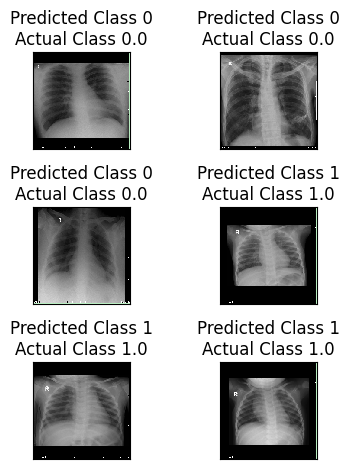

In [35]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_val[c], cmap="gray", interpolation='none')
    plt.title("Predicted Class {}\nActual Class {}".format(predicted_classes[c], y_val[c]))
    plt.tight_layout()
    i += 1

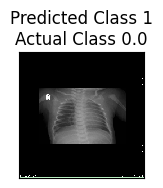

In [36]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_val[c], cmap="gray", interpolation='none')
    plt.title("Predicted Class {}\nActual Class {}".format(predicted_classes[c], y_val[c]))
    plt.tight_layout()